# Project 3-2: Dreambooth (45 pt)

In this project, we are going to implement an interesting work called Dreambooth [1]. Given a few images of a subject, Dreambooth finetunes the diffusion model and learns a new concept for that subject. After that, the new concept can be used in the finetuned diffusion model to generate new images of the given subject. We will use a few images of a corgi as an example, and "personalize" our own model to make it generate this corgi. In a word, we will get: <br>
1. a new embedding for our concept; <br>
2. a fintuned diffusion model. <br>

Please refer to [1] for more details. Note that this implementation will have some differences from the original paper. Similar to Project 3-1, we will use Stable Diffusion as our backbone model and diffusers library for implementation.

[1] Ruiz, Nataniel, et al. "Dreambooth: Fine tuning text-to-image diffusion models for subject-driven generation." CVPR 2023. <br>

In [13]:
##Hui: https://dreambooth.github.io/      https://github.com/google/dreambooth

## Task 1: Get started (2.5 pt)

Please make sure you install pytorch>=1.7, numpy, PIL, transformers and diffusers. <br>
Possible library versions: <br>
pytorch==1.12.1 <br>
torchvision==0.13.1 <br>
transformers==4.28.1 <br>
diffusers==0.16.1 <br>
You can basically install new packages based on the environment you use for Project 3-1.

In [14]:
#Import required libraries
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from diffusers import AutoencoderKL, DDIMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from PIL import Image
from torchvision import transforms
from tqdm.autonotebook import tqdm
from transformers import CLIPTextModel, CLIPTokenizer

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# suppress logs from transformers library
import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


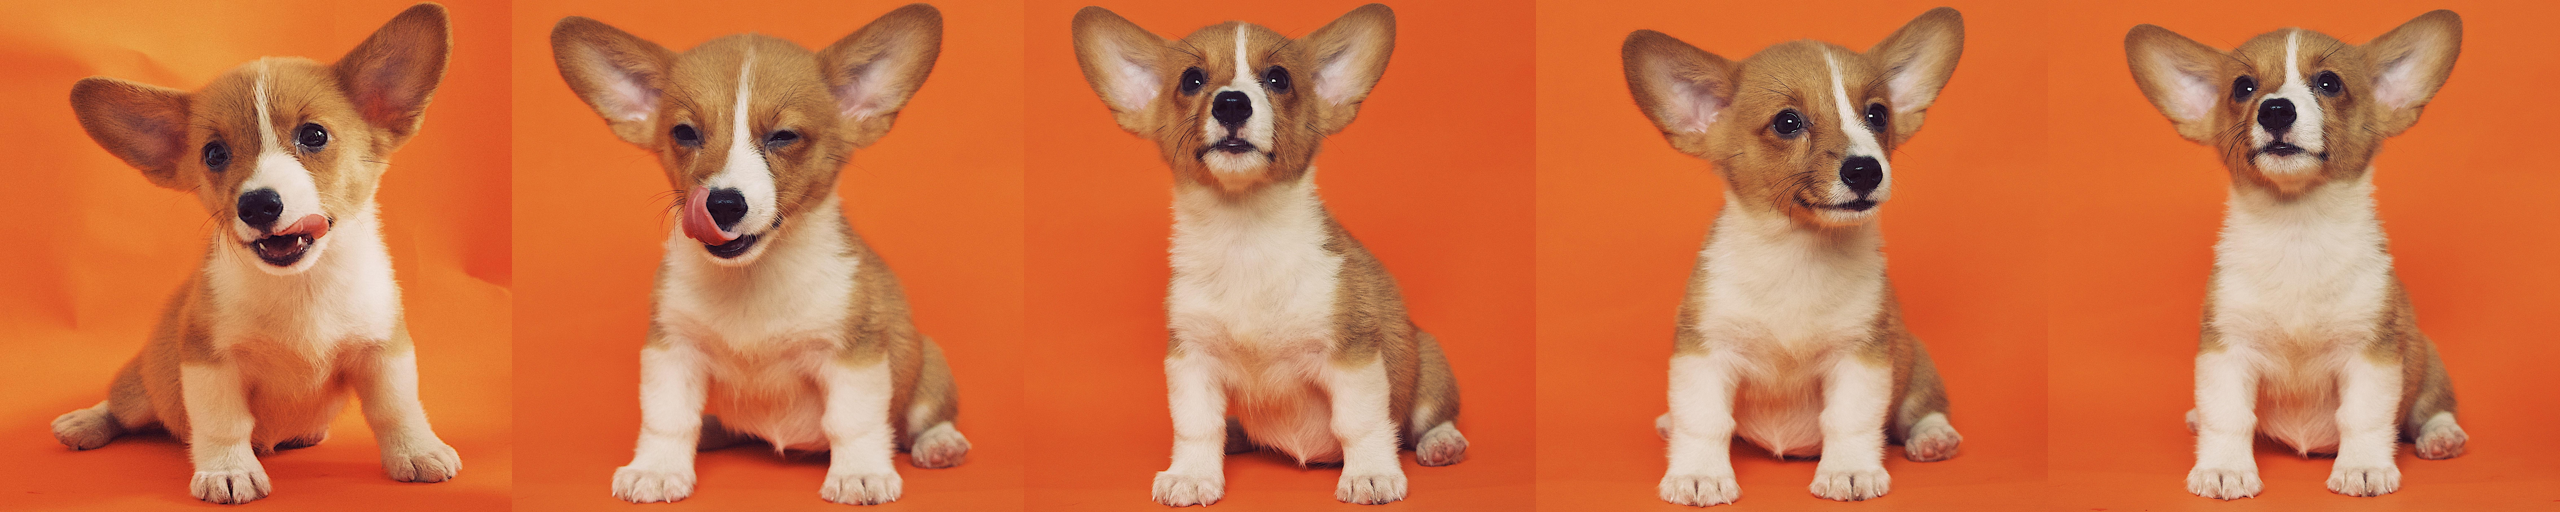

In [15]:
# TODO: run this cell and visualize the images we collected for the corgi.
# These images will be used to finetune the diffusion model.
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

images = []
image_dir = './dreambooth_imgs/corgi'
for img_name in os.listdir(image_dir):    
    image = Image.open(os.path.join(image_dir, img_name))
    images.append(image.resize((512, 512)))

image_grid(images, 1, len(images))

## Task 2: Prepare the data (2.5 pt)

In [16]:
placeholder_token = "<cute-corgi>"  # This is the new unique identifier for the corgi class.
initializer_token = "dog"  # We initialize the new embedding with the embedding for the "dog" class.

In [17]:
# We use a collection of the text template for prompting.
imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

In [18]:
# TODO: Set up the dataset for training
class DreamboothDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        size=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        placeholder_token="*",
        center_crop=False,
    ):

        self.data_root = data_root
        self.tokenizer = tokenizer
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]

        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == "train":
            self._length = self.num_images * repeats

        self.interpolation = {
            "linear": PIL.Image.LINEAR,
            "bilinear": PIL.Image.BILINEAR,
            "bicubic": PIL.Image.BICUBIC,
            "lanczos": PIL.Image.LANCZOS,
        }[interpolation]

        self.templates = imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = Image.open(self.image_paths[i % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        # TODO: we use package `random` to randomly choose a text template from self.templates, 
        # and fill the place holder with placeholder_string.
        text = (random.choice(self.templates)).format(self.placeholder_token)

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            h, w, = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example

## Task 3: Set up training (20 pt)

In [19]:
pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4"

tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

# Add the placeholder token in tokenizer
num_added_tokens = tokenizer.add_tokens(placeholder_token)
if num_added_tokens == 0:
    raise ValueError(
        f"The tokenizer already contains the token {placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )
# Get the token id of the placeholder token
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)

# We don't need to add intializer_token to the tokenizer since it is already in the vocabulary
token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
# Get the token id of the initializer token
initializer_token_id = token_ids[0]
print(len(tokenizer), token_ids, initializer_token_id)

49409 [1929] 1929


In [20]:
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)
noise_scheduler = DDIMScheduler.from_config(pretrained_model_name_or_path, subfolder="scheduler")

text_encoder.resize_token_embeddings(len(tokenizer))
token_embeds = text_encoder.get_input_embeddings().weight.data
# Initialize the placeholder token embedding with the initializer token embedding
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]
print(token_embeds.shape, placeholder_token_id, token_embeds[placeholder_token_id].shape)

torch.Size([49409, 768]) 49408 torch.Size([768])


In [21]:
def freeze_params(params):
    for param in params:
        param.requires_grad = False

# Freeze vae
freeze_params(vae.parameters())
# Freeze all parameters in the text encoder except for the token embeddings
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
freeze_params(params_to_freeze)

In [22]:
train_dataset = DreamboothDataset(
      data_root=image_dir,
      tokenizer=tokenizer,
      size=vae.sample_size,
      placeholder_token=placeholder_token,
      repeats=100,
      center_crop=False,
      set="train",
)

In [23]:
# TODO: Fill in the missing lines in the training function
def train(text_encoder, vae, unet, hyperparameters):
    train_batch_size = hyperparameters["train_batch_size"]
    gradient_accumulation_steps = hyperparameters["gradient_accumulation_steps"]
    learning_rate = hyperparameters["learning_rate"]
    max_train_steps = hyperparameters["max_train_steps"]
    output_dir = hyperparameters["output_dir"]
    gradient_checkpointing = hyperparameters["gradient_checkpointing"]
    save_steps = hyperparameters["save_steps"]

    if gradient_checkpointing:
        text_encoder.gradient_checkpointing_enable()
        unet.enable_gradient_checkpointing()

    # TODO: Create the dataloader using `train_dataset`
    from torch.utils.data import DataLoader ##Hui: add
    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

    if hyperparameters["scale_lr"]:
        learning_rate = (
            learning_rate * gradient_accumulation_steps * train_batch_size
        )

    # Initialize the optimizer
    optimizer = torch.optim.AdamW(
        list(text_encoder.get_input_embeddings().parameters()) + list(unet.parameters()),  # only optimize the embeddings
        lr=learning_rate,
    )

    # Move vae and unet to device
    vae.to(device)
    unet.to(device)
    text_encoder.to(device)

    # Keep vae in eval mode as we don't train it
    vae.eval()
    # Keep unet in train mode to enable gradient checkpointing
    unet.train()


    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    total_batch_size = train_batch_size * gradient_accumulation_steps

    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(max_train_steps))
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            # Convert images to latent space
            batch["pixel_values"] = batch["pixel_values"].to(device)
            batch["input_ids"] = batch["input_ids"].to(device)
            
            latents = vae.encode(batch["pixel_values"]).latent_dist.sample().detach()
            latents = latents * 0.18215 ##Hui: shape=torch.Size([4, 4, 64, 64])

            # Sample noise that we'll add to the latents
            noise = torch.rand_like(latents).to(device) # TODO: sample a random noise. What should be the shape of the noise?
            bsz = latents.shape[0]  ##Hui: ==4

            timesteps = torch.randint(low=0, high=100, size=(bsz,)).to(device) # TODO: Sample a random integer as the timestep for each image. 
                        # Hint: use `torch.randint()`.
                        # The shape of the tensor should be (bsz, ).
            
            #print(latents.shape, noise.shape, timesteps.shape)
            
            # Add noise to the latents
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Get the text embedding for conditioning
            encoder_hidden_states = text_encoder(batch["input_ids"])[0]

            ##Hui refers to: https://docs.ray.io/en/latest/train/examples/pytorch/dreambooth_finetuning.html
            ##Hui refers to: https://github.com/huggingface/diffusers/issues/3185
            noise_pred = unet(noisy_latents.to(device), timesteps.to(device), encoder_hidden_states.to(device)).sample # TODO: Predict the noise residual

            # Get the target for loss depending on the prediction type
            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(latents, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

            loss = F.mse_loss(noise_pred.float(), target.float()) # TODO: Calculate the MSE loss
            loss.backward()

            # Zero out the gradients for all token embeddings except the newly added
            # embeddings for the concept, as we only want to optimize the concept embeddings
            grads = text_encoder.get_input_embeddings().weight.grad
            # Get the index for tokens that we want to zero the grads for
            index_grads_to_zero = torch.arange(len(tokenizer)) != placeholder_token_id
            # Zero out the grads at the index_grads_to_zero. 
            grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)

            optimizer.step()
            optimizer.zero_grad()

            progress_bar.update(1)
            global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break
            
            if global_step % save_steps == 0:
                # Create the pipeline using using the trained modules and save it.
                pipeline = StableDiffusionPipeline.from_pretrained(
                    pretrained_model_name_or_path,
                    text_encoder=text_encoder,
                    tokenizer=tokenizer,
                    vae=vae,
                    unet=unet,
                )
                output_path = os.path.join(output_dir, "checkpoint-{}_{}".format(global_step, hyperparameters["learning_rate"]))
                pipeline.save_pretrained(output_path)
                # Also save the newly trained embeddings

    pipeline = StableDiffusionPipeline.from_pretrained(
        pretrained_model_name_or_path,
        text_encoder=text_encoder,
        tokenizer=tokenizer,
        vae=vae,
        unet=unet,
    )
    output_path = os.path.join(output_dir, "checkpoint-{}_{}".format(global_step, hyperparameters["learning_rate"]))
    pipeline.save_pretrained(output_path)

In [24]:
# Setting up all training hyperparameters.
# You can keep the other hyperparameters as they are, 
# but you can also try to change them to see if you can get better results.
hyperparameters = {
    "learning_rate": 5e-6,  # TODO: try to find a good setting between 1e-7 and 1e-6
    "scale_lr": True,
    "max_train_steps": 200,  # TODO: try to find a good setting between 50 and 500
    "save_steps": 100,  # We save the intermediate pipeline every save_steps steps
    "train_batch_size": 4,
    "gradient_accumulation_steps": 1,
    "gradient_checkpointing": True,
    "mixed_precision": "fp16",
    "seed": 20,
    "output_dir": "./output/dreambooth_corgi"
}
train(text_encoder, vae, unet, hyperparameters)


Steps:   0%|          | 0/200 [00:00<?, ?it/s]

RuntimeError: CUDA error: invalid argument
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
  if param.grad is not None:
    del param.grad  # free some memory
  torch.cuda.empty_cache()

## Task 4: Test our new concept! (20 pt)

What good output images should look like if you use your new concept of corgi for testing? <br>
1. The images should be of the same visual quality as the other Stable Diffusion images. <br>
2. The images should contain the corgi. <br>
3. The images should not look too similar as the training images. <br>
4. The images should correctly show the content of your prompt. (At least when your prompt is simple) <br>

Overfitting can easily happen especially when the training is too long. Here are some overfitting examples using the prompt "Photo of a \<cute-corgi\> swimming": <br>
<img src="exp_output/corgi_swimming.jpg" alt="Overfitting" width="800"/>

In [ ]:
# Load the pipeline we have trained.
steps = 100 # TODO: please decide which checkpoint to load
learning_rate = hyperparameters["learning_rate"]
pipe_path = os.path.join(hyperparameters["output_dir"], "checkpoint-{}_{}".format(steps, learning_rate))
pipe = StableDiffusionPipeline.from_pretrained(
    pipe_path,
    scheduler=DDIMScheduler.from_pretrained(pipe_path, subfolder="scheduler"),
    torch_dtype=torch.float16,
).to(device)

In [ ]:
# Run the cell and see if the generated images include the corgi in the reference images.
# If you want to train the model with new hyperparameters, 
# consider restart the runtime and run all cells again.
prompt = "Photo of a {} running on the beach".format(placeholder_token)

num_samples = 4
num_rows = 2

new_images = [] 
for _ in range(num_rows):
    images = pipe([prompt] * num_samples, num_inference_steps=50, guidance_scale=7.5).images
    new_images.extend(images)

grid = image_grid(new_images, num_rows, num_samples)
grid

In [ ]:
# We run this additional test to see 
# whether the model overfitts to the corgi so that it forgets 
# how to generate other subjects or not.
prompt = "Photo of a bear dancing in the forest"

num_samples = 4
num_rows = 1

new_images = [] 
for _ in range(num_rows):
    images = pipe([prompt] * num_samples, num_inference_steps=50, guidance_scale=7.5).images
    new_images.extend(images)

grid = image_grid(new_images, num_rows, num_samples)
grid

In [ ]:
# Run this additional test to see 
# whether the model overfitts to the corgi so that it forgets 
# how to generate subject of the same class as the corgi.
# In this case, the same class should be "dog".
# It's ok that you see some corgi-like dogs in the generated images.
prompt = "Photo of a dog running on the beach"

num_samples = 4
num_rows = 1

new_images = [] 
for _ in range(num_rows):
    images = pipe([prompt] * num_samples, num_inference_steps=50, guidance_scale=7.5).images
    new_images.extend(images)

grid = image_grid(new_images, num_rows, num_samples)
grid